In [1]:
# IGNORE THIS IF THE QISKIT.TOOLKIT VERSIONS WORK FOR YOU, OTHERWISE THIS WILL GET AROUND VERSION ISSUES
import types, sys
qt = types.ModuleType("qiskit.tools")
def parallel_map(func, values, *args, **kwargs):
    return list(map(func, values))
qt.parallel_map = parallel_map

# Minimal progress bar stub (used by the same module sometimes)
events = types.ModuleType("qiskit.tools.events")
class TextProgressBar:
    def __init__(self, *a, **k): pass
    def update(self, *a, **k): pass
    def __enter__(self): return self
    def __exit__(self, *exc): pass
events.TextProgressBar = TextProgressBar

sys.modules["qiskit.tools"] = qt
sys.modules["qiskit.tools.events"] = events


In [2]:
%pip install qiskit-nature
%pip install pyscf
%pip install qiskit==1.4.2
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 5.9 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.4 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 22.4 MB/s  0:00:00
  Attempting uninstall: qiskit0m╺━━━━━━━━━━━━━━━━━━━ 2/4 [symengine]
    Found existing installation: qiskit 2.2.3━━━━━━━━━━━━━━━━━ 2/4 [symengine]
    Uninstalling qiskit-2.2.3:90m╺━━━━━━━━━━━━━━━━━━━ 2/4 [symengine]
      Successfully uninstalled qiskit-2.2.3╺━━━━━━━━━ 3/4 [qiskit]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [qiskit]2m3/4 [qiskit]
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 6.2 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Electronic structure

## Introduction 

The molecular Hamiltonian is 

$$
\mathcal{H} = - \sum_I \frac{\nabla_{R_I}^2}{M_I} - \sum_i \frac{\nabla_{r_i}^2}{m_e} - \sum_I\sum_i  \frac{Z_I e^2}{|R_I-r_i|} + \sum_i \sum_{j>i} \frac{e^2}{|r_i-r_j|} + \sum_I\sum_{J>I} \frac{Z_I Z_J e^2}{|R_I-R_J|}
$$

Because the nuclei are much heavier than the electrons they do not move on the same time scale and therefore, the behavior of nuclei and electrons can be decoupled. This is the Born-Oppenheimer approximation.

Therefore, one can first tackle the electronic problem with the nuclear coordinates entering only as parameters. The energy levels of the electrons in the molecule can then be found by solving the non-relativistic time independent Schrödinger equation,

$$
\mathcal{H}_{\text{el}} |\Psi_{n}\rangle = E_{n} |\Psi_{n}\rangle
$$

where 

$$
\mathcal{H}_{\text{el}} = - \sum_i \frac{\nabla_{r_i}^2}{m_e} - \sum_I\sum_i  \frac{Z_I e^2}{|R_I-r_i|} + \sum_i \sum_{j>i} \frac{e^2}{|r_i-r_j|}.
$$

In particular the ground state energy is given by:
$$
E_0 = \frac{\langle \Psi_0 | H_{\text{el}} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}
$$
where $\Psi_0$ is the ground state of the system. 

However, the dimensionality of this problem grows exponentially with the number of degrees of freedom. To tackle this issue we would like to prepare $\Psi_0$ on a quantum computer and measure the Hamiltonian expectation value (or $E_0$) directly. 

So how do we do that concretely? 


## Starting from the Hartree-Fock solution 

A good starting point for solving this problem is the Hartree-Fock (HF) method. This method approximates the N-body problem by N one-body problems where each electron evolves in the mean-field of the others. Classically solving the HF equations is efficient and leads to the exact exchange energy but does not include any electron correlation. Therefore, it is usually a good starting point to which to add correlation. 

The Hamiltonian can then be re-expressed in the basis of the solutions of the HF method, also called Molecular Orbitals (MOs):

$$
\hat{H}_{elec}=\sum_{pq} h_{pq} \hat{a}^{\dagger}_p \hat{a}_q + 
\frac{1}{2} \sum_{pqrs} h_{pqrs}  \hat{a}^{\dagger}_p \hat{a}^{\dagger}_q \hat{a}_r  \hat{a}_s
$$
with the 1-body integrals
$$
h_{pq} = \int \phi^*_p(r) \left( -\frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{R_I- r} \right)   \phi_q(r)dr
$$
and 2-body integrals
$$
h_{pqrs} = \int \frac{\phi^*_p(r_1)  \phi^*_q(r_2) \phi_r(r_2)  \phi_s(r_1)}{|r_1-r_2|}dr_1dr_2.
$$

The MOs ($\phi_u$) can be occupied or virtual (unoccupied). One MO can contain 2 electrons. However, in what follows we actually work with Spin Orbitals which are associated with a spin up ($\alpha$) of spin down ($\beta$) electron. Thus Spin Orbitals can contain one electron or be unoccupied.

Note: when referring to the number of orbitals, we will be using the number of _spatial_ orbitals. This refers to any orbital in Cartesian space (whether its a molecular orbital or in another basis does not matter here). Each spatial orbital is then generally split into two _spin_ orbitals.

We now show how to concretely realise these steps with Qiskit.

### Obtaining an initial Hartree-Fock solution

Qiskit is interfaced with different classical codes which are able to find the HF solutions. Interfacing between Qiskit and the following codes is already available:

* Gaussian
* Psi4
* PySCF

In the following we set up a PySCF driver, for the hydrogen molecule at equilibrium bond length (0.735 angstrom) in the singlet state and with no charge. 

In [3]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

Running this driver, will yield an `ElectronicStructureProblem`, Qiskit Nature's representation of the electronic structure problem which we are interested in solving. For further information about the drivers, see https://qiskit-community.github.io/qiskit-nature/apidocs/qiskit_nature.second_q.drivers.html

In [4]:
problem = driver.run()
print(problem)

### The `ElectronicStructureProblem` and its components

Let us spend some time to understand this problem instance and its components.

#### The `ElectronicEnergy` Hamiltonian

The most important aspect is the internal Hamiltonian; in this case an `ElectronicEnergy` hamiltonian. This class is able to generate the second-quantized operator from the 1- and 2-body integrals which the classical code has computed for us.

> **IMPORTANT:** The container class for the integral coefficients (`PolynomialTensor`) requires the 2-body terms to be provided in **physicist order**!

In [5]:
hamiltonian = problem.hamiltonian

coefficients = hamiltonian.electronic_integrals
print(coefficients.alpha)

Polynomial Tensor
 "+-":
array([[-1.25633907e+00, -1.37083854e-17],
       [-6.07732712e-17, -4.71896007e-01]])
 "++--":
array([6.75710155e-01, 1.38777878e-16, 1.80931200e-01, 6.64581730e-01,
       5.55111512e-17, 6.98573723e-01])


In [6]:
second_q_op = hamiltonian.second_q_op()
print(second_q_op)

Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.3322908651276482 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.3322908651276482 * ( +_0 +_3 -_3 -_0 )
+ 0.09046559989211572 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211572 * ( +_0 +_1 -_0 -_1 )
+ 0.09046559989211572 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211572 * ( +_0 +_3 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211572 * ( +_1 +_1 -_0 -_0 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211572 * ( +_1 +_3 -_2 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.34928686136600884 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.34928686136600884 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.3322908651276482 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507740175813 * ( +_2 +_2 -_2 -_2 )
+ 0.3322908651276482 * ( +_2 +_3 -_3 -_2 )
+ 0.09046559989211572 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211572 *

Note, that this is purely the **electronic** Hamiltonian of the system. That means, that the _nuclear repulsion energy_ is not included. Instead, Qiskit Nature will add this constant energy offset in a post-processing step, in order to compute the total energy of your system. To learn how to include the nuclear repulsion energy in this operator, please refer to the documentation of the `ElectronicEnergy` class [here](https://qiskit-community.github.io/qiskit-nature/stubs/qiskit_nature.second_q.hamiltonians.ElectronicEnergy.html).

In [7]:
hamiltonian.nuclear_repulsion_energy  # NOT included in the second_q_op above

np.float64(0.7199689944489797)

#### More attributes of the `ElectronicStructureProblem`

Below we list some additional attributes of our `problem` instance:

In [8]:
problem.molecule

MoleculeInfo(symbols=['H', 'H'], coords=[(0.0, 0.0, 0.0), (0.0, 0.0, 1.3889487015553204)], multiplicity=1, charge=0, units=<DistanceUnit.BOHR: 'Bohr'>, masses=[np.int64(1), np.int64(1)])

In [9]:
problem.reference_energy

np.float64(-1.116998996754004)

In [10]:
problem.num_particles

(1, 1)

In [11]:
problem.num_spatial_orbitals

2

In [12]:
problem.basis

<ElectronicBasis.MO: 'molecular'>

To learn more about the basis of your problem, please refer to the tutorial on the [`BasisTransformer`](05_problem_transformers.ipynb).

#### Additional observables

The `ElectronicStructureProblem` also contains additional operator factories, which will generate observables to be evaluated at the ground- and excited-states at the end of your computation.

In [13]:
problem.properties

In [14]:
problem.properties.particle_number

In [15]:
problem.properties.angular_momentum

In [16]:
problem.properties.magnetization

In [17]:
problem.properties.electronic_dipole_moment

For more information about these properties, please refer to [their tutorial](09_properties.ipynb).

## Solving the `ElectronicStructureProblem`

In the following, we will compute the ground-state of our problem instance. To learn more about the individual components that go into the `GroundStateSolver`, please refer to the [ground state tutorial](./03_ground_state_solvers.ipynb).

In [18]:
#from qiskit_algorithms import NumPyMinimumEigensolver
#from qiskit_nature.second_q.algorithms import GroundStateEigensolver
#from qiskit_nature.second_q.mappers import JordanWignerMapper

#solver = GroundStateEigensolver(
#    JordanWignerMapper(),
#    NumPyMinimumEigensolver(),
#)

In [19]:
#result = solver.solve(problem)
#print(result)

In [20]:
#import tutorial_magics

#%qiskit_version_table
#%qiskit_copyright

In [21]:
# 0. Imports


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit

# I. define the H2 molecule for a range of 11 inter-atomic distances between 0.5 A and 2.5 A

# 1. Define the distances you want to check
distances_to_check = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]
#distances_to_check = [0.5, 0.7, 2.5]

# 2. Define the basic, unchanging properties of the molecule
molecule_name = "H2"
charge = 0
spin = 0 # (for H2, this means no net spin)


list_of_quantum_problems = []
for r in distances_to_check:
    
    # 1. THE INPUT (for this loop iteration)
    # Define the "geometry" for this specific distance 'r'
    # This is the "recipe" you give to the classical driver.
    current_geometry = f"H 0 0 0; H 0 0 {r}"
    # This string says:
    # "Put one Hydrogen atom at (0, 0, 0)"
    # "Put the other Hydrogen atom at (0, 0, r)"
    
    # 2. THE "MAGIC" (The Task Itself)
    # You tell Qiskit Nature to...
    # ...use PySCF (the "driver")...
    # ...to "define" the molecule...
    # ...using your 'current_geometry', 'charge', and 'spin'.
    
    problem_at_this_distance = PySCFDriver(
        atom=current_geometry,
        basis="sto3g",
        charge=charge,
        spin=spin,
        unit=DistanceUnit.ANGSTROM
    ).run() 
    
    # 3. THE OUTPUT (for this loop iteration)
    # The 'problem_at_this_distance' object is your output.
    # It's a big, complex Python object that contains *everything*
    # the classical calculator figured out.
    
    # You then save this object to your list.
    list_of_quantum_problems.append(problem_at_this_distance)

print(list_of_quantum_problems)
print(f"Generated {len(list_of_quantum_problems)} problems for H2.\n")

[<qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem object at 0x7479ec5029e0>, <qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem object at 0x7479ec5014b0>, <qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem object at 0x7479ec500280>, <qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem object at 0x7479ec56c490>, <qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem object at 0x7479ec56ce20>, <qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem object at 0x7479ec56d8d0>, <qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem object at 0x7479ec56e5c0>, <qiskit_nature.second_q.problems.electronic_structure_problem.ElectronicStructureProblem object at 0x7479ec56ef20>, <qiskit_nature.second_q.problems.electronic_structure_problem.Electroni

In [33]:
import numpy as np
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.formats import MoleculeInfo


# II. Generate the Hamiltonian: 
# For each distance r i r i ​ , generate the corresponding 
# Electronic Structure Hamiltonian in the second-quantized form, 
# map it to a Qubit Hamiltonian (using mappers like Jordan-Wigner or Parity), 
# and reduce the number of qubits using symmetries.

# We will store our final translated "quantum recipes" here
mapped_hamiltonians = []
# We also save the mappers, as they are crucial for VQE
reduced_mappers = {}

# Choose your mapper. JordanWignerMapper is a great default.
# ParityMapper is another good choice that also reduces 2 qubits.
# mapper_type = JordanWignerMapper() 
mapper_type = ParityMapper()

for i, problem in enumerate(list_of_quantum_problems):
    distance = distances_to_check[i]
    print(f"Processing distance r = {distance:.2f} Å...")


    # 1. Get the second-quantized Hamiltonian CONTAINER
    hamiltonian_2q_container = problem.hamiltonian

    # --- FIX: Get the OPERATOR from the container ---
    # We need the operator itself (a FermionicOp), 
    # not the ElectronicEnergy container object.
    hamiltonian_2q_op = hamiltonian_2q_container.second_q_op()
    # ------------------------------------------------
    
    # 2. Reduce the number of qubits using symmetries
    tapered_mapper = problem.get_tapered_mapper(mapper_type)

    # 3. Map the second-quantized OPERATOR to a Qubit Hamiltonian
    # --- FIX: We map the operator (hamiltonian_2q_op), not the container ---
    qubit_hamiltonian = tapered_mapper.map(hamiltonian_2q_op)

    # --- Let's see the effect of the reduction ---
    # For H2, we have 2 spatial orbitals (1s_A, 1s_B)
    # This means 2 * 2 = 4 qubits originally (spin-up/down for each)
    num_qubits_original = problem.num_spatial_orbitals * 2
    num_qubits_reduced = qubit_hamiltonian.num_qubits
    
    print(f"  Original number of qubits: {num_qubits_original}")
    print(f"  Number of qubits after symmetry reduction: {num_qubits_reduced}")

    # 4. Save the results for this distance
    mapped_hamiltonians.append(qubit_hamiltonian)
    reduced_mappers[distance] = tapered_mapper

print("\nTask complete. You now have:")
print(f"1. 'mapped_hamiltonians': A list of {len(mapped_hamiltonians)} Qubit Hamiltonians.")
print(f"2. 'reduced_mappers': A dictionary of mappers for each distance.")

Processing distance r = 0.50 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 0.70 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 0.90 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.10 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.30 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.50 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.70 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.90 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 2.10 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduc

Running VQE calculations for each distance...
  Distance: 0.50 Å, Total Energy: -1.055159 Hartree
  Distance: 0.70 Å, Total Energy: -1.136189 Hartree
  Distance: 0.90 Å, Total Energy: -1.120560 Hartree
  Distance: 1.10 Å, Total Energy: -1.079193 Hartree
  Distance: 1.30 Å, Total Energy: -1.035186 Hartree
  Distance: 1.50 Å, Total Energy: -0.998149 Hartree
  Distance: 1.70 Å, Total Energy: -0.971427 Hartree
  Distance: 1.90 Å, Total Energy: -0.954339 Hartree
  Distance: 2.10 Å, Total Energy: -0.944374 Hartree
  Distance: 2.30 Å, Total Energy: -0.938922 Hartree
  Distance: 2.50 Å, Total Energy: -0.936055 Hartree

Running classical solver for comparison...
Classical solver finished.

Plotting results...


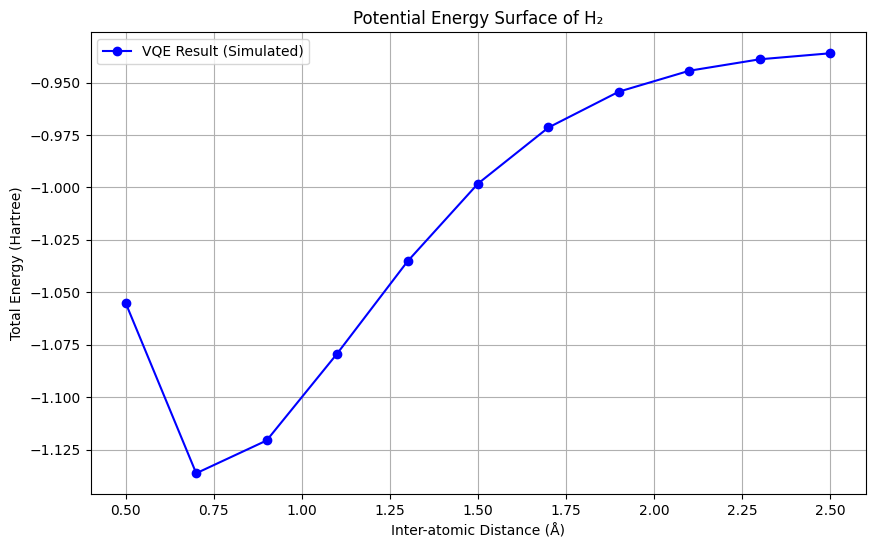

In [34]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import StatevectorEstimator

# III. VQE Implementation

# --- 3a. Define the components from your image ---

# 1. The "Quantum" Part: Ansatz
# We'll use the "simpler EfficientSU2" as suggested.
# We get the number of qubits from our reduced Hamiltonian.
num_qubits = mapped_hamiltonians[0].num_qubits
ansatz = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement='linear')

# 2. The "Classical" Part: Optimizer
# We'll use "SLSQP" as suggested.
optimizer = SLSQP(maxiter=1000)

# 3. The "Calculator": Estimator
# This is the "backend" that runs the circuit and calculates
# the expectation value <Psi|H|Psi>.
estimator = StatevectorEstimator()

# --- 3b. Build the VQE Solver ---
# The VQE algorithm "glues" the estimator, ansatz, and optimizer together.
vqe_solver = VQE(estimator, ansatz, optimizer)

# --- 3c. Run the VQE loop to find the energy for EACH distance ---
# We will store our final energy points here
vqe_energies = []
print("Running VQE calculations for each distance...")

for i in range(len(distances_to_check)):
    dist = distances_to_check[i]
    problem = list_of_quantum_problems[i]
    qubit_ham = mapped_hamiltonians[i]

    # Run the VQE algorithm!
    # This automatically does the optimization: "find the parameters (theta)
    # that minimize the expectation value"
    vqe_result = vqe_solver.compute_minimum_eigenvalue(qubit_ham)
    
    # The VQE result is *only* the electronic energy
    vqe_electronic_energy = vqe_result.eigenvalue.real
    
    # We must add the nuclear repulsion energy (a simple classical value)
    # to get the *total* energy of the molecule.
    nuclear_repulsion_energy = problem.hamiltonian.nuclear_repulsion_energy
    total_energy = vqe_electronic_energy + nuclear_repulsion_energy
    
    vqe_energies.append(total_energy)
    print(f"  Distance: {dist:.2f} Å, Total Energy: {total_energy:.6f} Hartree")


# --- For comparison: Let's solve it "Exactly" with a classical solver ---
# This uses the NumPy solver, which doesn't use VQE. It just finds the
# mathematically perfect answer. This is our "ground truth."
print("\nRunning classical solver for comparison...")
exact_energies = []
for i, problem in enumerate(list_of_quantum_problems):
    solver = GroundStateEigensolver(
        problem.get_tapered_mapper(mapper_type),
        NumPyMinimumEigensolver(),
    )
    result = solver.solve(problem)
    exact_energies.append(result.total_energies[0])
print("Classical solver finished.")


# --- 3d. Plot the Final Potential Energy Surface ---
print("\nPlotting results...")
plt.figure(figsize=(10, 6))
#plt.plot(distances_to_check, exact_energies, 'go--', label='Exact Classical Answer')
plt.plot(distances_to_check, vqe_energies, 'bo-', label='VQE Result (Simulated)')
plt.xlabel('Inter-atomic Distance (Å)')
plt.ylabel('Total Energy (Hartree)')
plt.title('Potential Energy Surface of H₂')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# --- Error mitigation via ZNE on a noisy Aer Estimator ---

# 0) Ensure Aer is available (run once)
%pip install -q qiskit-aer

import numpy as np
import math
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP

# A. Build a *base* noise model. We'll scale its strengths later by λ.
def build_noise_model(scale: float = 1.0) -> NoiseModel:
    """
    Simple depolarizing + readout noise model.
    scale=1.0 is the 'base' noise; scale>1 increases noise.
    """
    nm = NoiseModel()

    # Choose reasonable small base errors then scale them.
    # (Tune these if you want stronger/weaker noise.)
    p1_base = 1e-3   # 0.1% 1q depolarizing
    p2_base = 1e-2   # 1.0% 2q depolarizing
    ro_base = 0.02   # 2% readout flip prob

    p1 = min(p1_base * scale, 1.0)
    p2 = min(p2_base * scale, 1.0)
    ro = min(ro_base * scale, 0.45)  # cap readout error for sanity

    # EfficientSU2 mainly uses rz, sx, x, cx; add depolarizing on those.
    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['x', 'sx', 'rz'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])

    # Symmetric readout confusion matrix
    ro_matrix = [[1 - ro, ro],
                 [ro, 1 - ro]]
    nm.add_all_qubit_readout_error(ReadoutError(ro_matrix))
    return nm

# B. One-shot helper: compute *total* energy with VQE for a given noise scale λ.
def vqe_energy_with_noise(qubit_op, nuc_rep_energy, ansatz, optimizer, shots=8192, scale=1.0, seed=123):
    est = AerEstimator(
        backend_options={'noise_model': build_noise_model(scale)},
        run_options={'shots': shots, 'seed': seed},
    )
    vqe = VQE(est, ansatz, optimizer)
    res = vqe.compute_minimum_eigenvalue(qubit_op)
    e_tot = float(res.eigenvalue.real) + float(nuc_rep_energy)
    return e_tot

# C. ZNE wrapper: run at λ ∈ scales, then extrapolate to λ → 0
def zne_mitigated_energy(qubit_op, nuc_rep_energy, ansatz, optimizer, scales=(1.0, 2.0, 3.0), shots=8192, seed=123):
    scales = np.array(scales, dtype=float)
    energies = []
    for lam in scales:
        e = vqe_energy_with_noise(qubit_op, nuc_rep_energy, ansatz, optimizer, shots=shots, scale=lam, seed=seed)
        energies.append(e)
    energies = np.array(energies, dtype=float)

    # Linear fit: E(λ) ≈ a λ + b → E(0) = b
    a_lin, b_lin = np.polyfit(scales, energies, 1)
    e_lin = float(b_lin)

    # Quadratic (Richardson-like) fit if we have ≥3 points: E(λ) ≈ a λ^2 + b λ + c → E(0) = c
    e_quad = None
    if len(scales) >= 3:
        a2, b2, c2 = np.polyfit(scales, energies, 2)
        e_quad = float(c2)

    return {
        'scales': scales,
        'noisy_energies': energies,
        'mitigated_linear': e_lin,
        'mitigated_quadratic': e_quad,
    }


Note: you may need to restart the kernel to use updated packages.


In [37]:
# === TASK 2: H3+ (equilateral) — PES + r_eq via VQE and exact (NumPy) ===

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper

from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import StatevectorEstimator

In [38]:
# --- 1) Geometry helper for equilateral H3+ ---
def h3p_equilateral_geometry(r_angstrom: float) -> str:
    # Equilateral triangle in XY plane with side length r
    x2, y2, z2 = r_angstrom, 0.0, 0.0
    x3, y3, z3 = r_angstrom/2.0, (math.sqrt(3)/2.0)*r_angstrom, 0.0
    return f"H 0.0 0.0 0.0; H {x2} {y2} {z2}; H {x3} {y3} {z3}"

In [39]:
# --- 2) Scan a range of r values (Å) ---
h3p_distances = np.linspace(0.6, 1.6, 11)  # adjust granularity if you want
#h3p_distances = np.linspace(0.90, 1.10, 21)  # 0.01 Å steps

charge = +1
spin = 0
basis = "sto3g"

problems = []
qubit_ops = []
nuc_rep = []
tapered_mappers = {}
mapper_type = ParityMapper()

print("Building problems and mapping to qubits...")
for r in h3p_distances:
    drv = PySCFDriver(
        atom=h3p_equilateral_geometry(r),
        basis=basis,
        charge=charge,
        spin=spin,
        unit=DistanceUnit.ANGSTROM,
    )
    prob = drv.run()
    problems.append(prob)

    # second-quantized (fermionic) operator
    ferm_op = prob.hamiltonian.second_q_op()

    # parity + automatic symmetry tapering from the problem
    tapered = prob.get_tapered_mapper(mapper_type)
    qop = tapered.map(ferm_op)

    qubit_ops.append(qop)
    tapered_mappers[r] = tapered
    nuc_rep.append(prob.hamiltonian.nuclear_repulsion_energy)

    n_qubits_orig = prob.num_spatial_orbitals * 2
    print(f"  r={r:.2f} Å: qubits original={n_qubits_orig}, reduced={qop.num_qubits}")

Building problems and mapping to qubits...
  r=0.60 Å: qubits original=6, reduced=4
  r=0.70 Å: qubits original=6, reduced=4
  r=0.80 Å: qubits original=6, reduced=4
  r=0.90 Å: qubits original=6, reduced=4
  r=1.00 Å: qubits original=6, reduced=4
  r=1.10 Å: qubits original=6, reduced=4
  r=1.20 Å: qubits original=6, reduced=3
  r=1.30 Å: qubits original=6, reduced=4
  r=1.40 Å: qubits original=6, reduced=4
  r=1.50 Å: qubits original=6, reduced=4
  r=1.60 Å: qubits original=6, reduced=4


In [44]:
# --- 3) Set up VQE (keep it light for hackathon speed) ---
num_qubits = qubit_ops[0].num_qubits
ansatz = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement="linear")
optimizer = SLSQP(maxiter=500)
estimator = StatevectorEstimator()
vqe = VQE(estimator, ansatz, optimizer)

In [41]:
# --- 4) Compute energies over the scan ---
vqe_energies = []
exact_energies = []

print("\nRunning VQE and exact (NumPy) energies...")
for i, r in enumerate(h3p_distances):
    # VQE electronic energy
    vqe_res = vqe.compute_minimum_eigenvalue(qubit_ops[i])
    e_vqe_elec = float(vqe_res.eigenvalue.real)
    e_vqe_total = e_vqe_elec + float(nuc_rep[i])
    vqe_energies.append(e_vqe_total)

    # “Exact” on the same qubit H via dense diagonalization
    exact_res = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_ops[i])
    e_exact_elec = float(exact_res.eigenvalue.real)
    e_exact_total = e_exact_elec + float(nuc_rep[i])
    exact_energies.append(e_exact_total)

    print(f"  r={r:.2f} Å -> VQE: {e_vqe_total:+.6f} Ha | Exact: {e_exact_total:+.6f} Ha")


Running VQE and exact (NumPy) energies...
  r=0.60 Å -> VQE: -1.006824 Ha | Exact: -1.015516 Ha
  r=0.70 Å -> VQE: -1.152109 Ha | Exact: -1.161762 Ha
  r=0.80 Å -> VQE: -1.213186 Ha | Exact: -1.235726 Ha
  r=0.90 Å -> VQE: -1.242330 Ha | Exact: -1.267587 Ha
  r=1.00 Å -> VQE: -1.261162 Ha | Exact: -1.274275 Ha
  r=1.10 Å -> VQE: -1.233620 Ha | Exact: -1.265573 Ha
  r=1.20 Å -> VQE: -1.247446 Ha | Exact: -1.247446 Ha
  r=1.30 Å -> VQE: -1.182822 Ha | Exact: -1.223782 Ha
  r=1.40 Å -> VQE: -1.176817 Ha | Exact: -1.197242 Ha
  r=1.50 Å -> VQE: -1.167469 Ha | Exact: -1.169684 Ha
  r=1.60 Å -> VQE: -1.177178 Ha | Exact: -1.177178 Ha


In [42]:
# --- 5) Find r_eq from the exact curve (you can also report VQE min) ---
i_min_exact = int(np.argmin(exact_energies))
req_exact = float(h3p_distances[i_min_exact])
emin_exact = float(exact_energies[i_min_exact])

i_min_vqe = int(np.argmin(vqe_energies))
req_vqe = float(h3p_distances[i_min_vqe])
emin_vqe = float(vqe_energies[i_min_vqe])

print("\n=== Estimated equilibrium bond length r_eq (equilateral H3+) ===")
print(f"From Exact curve: r_eq ≈ {req_exact:.3f} Å, E ≈ {emin_exact:+.6f} Ha")
print(f"From VQE curve : r_eq ≈ {req_vqe:.3f} Å, E ≈ {emin_vqe:+.6f} Ha")


=== Estimated equilibrium bond length r_eq (equilateral H3+) ===
From Exact curve: r_eq ≈ 1.000 Å, E ≈ -1.274275 Ha
From VQE curve : r_eq ≈ 1.000 Å, E ≈ -1.261162 Ha


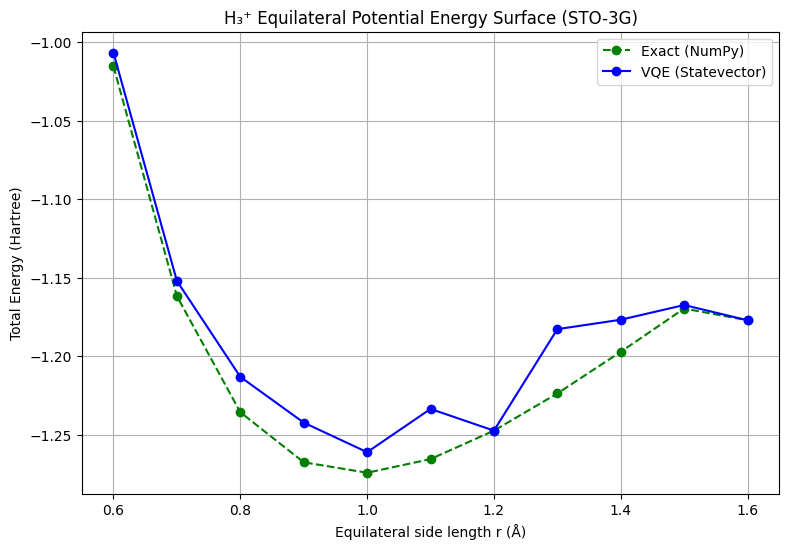

In [43]:
# --- 6) Plot PES ---
plt.figure(figsize=(9,6))
plt.plot(h3p_distances, exact_energies, 'go--', label='Exact (NumPy)')
plt.plot(h3p_distances, vqe_energies,   'bo-',  label='VQE (Statevector)')
plt.xlabel('Equilateral side length r (Å)')
plt.ylabel('Total Energy (Hartree)')
plt.title('H₃⁺ Equilateral Potential Energy Surface (STO-3G)')
plt.grid(True); plt.legend()
plt.show()

In [1]:
# --- ZNE on Aer: define helpers + run over your existing H3+ data in one go ---

# If Aer isn't installed in this kernel, install it quietly
%pip install -q qiskit-aer

import math, numpy as np, matplotlib.pyplot as plt

# 1) Imports for noise + primitives + VQE
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import EfficientSU2

# 2) Helpers
def build_noise_model(scale: float = 1.0) -> NoiseModel:
    """Simple depolarizing + readout noise model; scaled by 'scale'."""
    nm = NoiseModel()
    p1_base, p2_base, ro_base = 1e-3, 1e-2, 0.02   # base error rates
    p1 = min(p1_base * scale, 1.0)
    p2 = min(p2_base * scale, 1.0)
    ro = min(ro_base * scale, 0.45)

    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['x','sx','rz'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    ro_matrix = [[1 - ro, ro],[ro, 1 - ro]]
    nm.add_all_qubit_readout_error(ReadoutError(ro_matrix))
    return nm

def vqe_energy_with_noise(qubit_op, nuc_rep_energy, ansatz, optimizer, shots=8192, scale=1.0, seed=123):
    est = AerEstimator(
        backend_options={'noise_model': build_noise_model(scale)},
        run_options={'shots': shots, 'seed': seed},
    )
    vqe = VQE(est, ansatz, optimizer)
    res = vqe.compute_minimum_eigenvalue(qubit_op)
    return float(res.eigenvalue.real) + float(nuc_rep_energy)

def zne_mitigated_energy(qubit_op, nuc_rep_energy, ansatz, optimizer, scales=(1.0,2.0,3.0), shots=8192, seed=123):
    scales = np.array(scales, float)
    noisy_E = np.array([vqe_energy_with_noise(qubit_op, nuc_rep_energy, ansatz, optimizer,
                                              shots=shots, scale=lam, seed=seed)
                        for lam in scales], float)
    # Linear fit: E(lam) ≈ a*lam + b -> E(0) = b
    a_lin, b_lin = np.polyfit(scales, noisy_E, 1)
    e_lin = float(b_lin)
    e_quad = None
    if len(scales) >= 3:
        a2, b2, c2 = np.polyfit(scales, noisy_E, 2)
        e_quad = float(c2)
    return {'scales': scales, 'noisy_energies': noisy_E, 'mitigated_linear': e_lin, 'mitigated_quadratic': e_quad}

# 3) Recreate ansatz/optimizer (or reuse yours)
num_qubits = qubit_ops[0].num_qubits
ansatz = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement="linear")
optimizer = SLSQP(maxiter=300)

# 4) If exact_energies not computed earlier, compute them now (for plotting/reference)
if 'exact_energies' not in locals():
    exact_energies = []
    for i, r in enumerate(h3p_distances):
        er = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_ops[i]).eigenvalue.real
        exact_energies.append(float(er) + float(nuc_rep[i]))

# 5) Run ZNE scans
zne_scales = (1.0, 2.0, 3.0)
shots = 8192
vqe_noisy_base, vqe_zne_linear, vqe_zne_quadratic = [], [], []

print("Running ZNE across distances...")
for i, r in enumerate(h3p_distances):
    z = zne_mitigated_energy(qubit_ops[i], nuc_rep[i], ansatz, optimizer,
                             scales=zne_scales, shots=shots, seed=123)
    vqe_noisy_base.append(float(z['noisy_energies'][0]))  # λ=1
    vqe_zne_linear.append(float(z['mitigated_linear']))
    vqe_zne_quadratic.append(float(z['mitigated_quadratic']) if z['mitigated_quadratic'] is not None else np.nan)
    print(f"  r={r:.2f} Å  noisy:{z['noisy_energies'][0]:+.6f}  "
          f"ZNE_lin:{z['mitigated_linear']:+.6f}  "
          f"ZNE_quad:{(z['mitigated_quadratic'] if z['mitigated_quadratic'] is not None else float('nan')):+.6f}")

# 6) r_eq from ZNE-linear
d = np.array(h3p_distances, float)
E_noisy   = np.array(vqe_noisy_base, float)
E_zne_lin = np.array(vqe_zne_linear, float)
E_zne_quad= np.array(vqe_zne_quadratic, float)

i_eq_zne = int(np.nanargmin(E_zne_lin))
req_zne  = float(d[i_eq_zne]); emin_zne = float(E_zne_lin[i_eq_zne])
print(f"\n=== ZNE result ===\nZNE-linear r_eq ≈ {req_zne:.3f} Å, E ≈ {emin_zne:+.6f} Ha")

# 7) Plot: exact vs noisy vs ZNE (and quadratic if present)
plt.figure(figsize=(9,6))
plt.plot(d, exact_energies, 'g^--', label='Exact (NumPy)')
plt.plot(d, E_noisy,       'rx-',  label='VQE (noisy, λ=1)')
plt.plot(d, E_zne_lin,     'bo-',  label='VQE + ZNE (linear)')
if not np.all(np.isnan(E_zne_quad)):
    plt.plot(d, E_zne_quad,'c.-',  label='VQE + ZNE (quadratic)')
plt.xlabel('Equilateral side length r (Å)')
plt.ylabel('Total Energy (Hartree)')
plt.title('H₃⁺ PES: Exact vs Noisy VQE vs ZNE-mitigated (STO-3G)')
plt.grid(True); plt.legend()
plt.show()


Note: you may need to restart the kernel to use updated packages.


NameError: name 'qubit_ops' is not defined

In [ ]:
import matplotlib.pyplot as plt
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import EfficientSU2

# Reuse your ansatz/optimizer or recreate them consistently with your mapping
num_qubits = qubit_ops[0].num_qubits
ansatz = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement="linear")
optimizer = SLSQP(maxiter=300)

# Choose noise scales for ZNE and shot count
zne_scales = (1.0, 2.0, 3.0)
shots = 8192

vqe_noisy_base = []        # energy at λ=1 (noisy)
vqe_zne_linear = []        # ZNE-mitigated (linear)
vqe_zne_quadratic = []     # ZNE-mitigated (quadratic), if available

print("Running ZNE across distances...")
for i, r in enumerate(h3p_distances):
    z = zne_mitigated_energy(
        qubit_op=qubit_ops[i],
        nuc_rep_energy=nuc_rep[i],
        ansatz=ansatz,
        optimizer=optimizer,
        scales=zne_scales,
        shots=shots,
        seed=123,
    )
    vqe_noisy_base.append(float(z['noisy_energies'][0]))  # λ=1
    vqe_zne_linear.append(float(z['mitigated_linear']))
    vqe_zne_quadratic.append(float(z['mitigated_quadratic']) if z['mitigated_quadratic'] is not None else np.nan)
    print(f"  r={r:.2f} Å  noisy:{z['noisy_energies'][0]:+.6f}  ZNE_lin:{z['mitigated_linear']:+.6f}  ZNE_quad:{(z['mitigated_quadratic'] if z['mitigated_quadratic'] is not None else float('nan')):+.6f}")

# Convert to arrays
d = np.array(h3p_distances, float)
E_noisy = np.array(vqe_noisy_base, float)
E_zne_lin = np.array(vqe_zne_linear, float)
E_zne_quad = np.array(vqe_zne_quadratic, float)

# Find r_eq from ZNE (use linear; quadratic if you want)
i_eq_zne = int(np.nanargmin(E_zne_lin))
req_zne = float(d[i_eq_zne])
emin_zne = float(E_zne_lin[i_eq_zne])

# You already computed exact_energies earlier; if not, compute similarly with NumPyMinimumEigensolver.
# i_eq_exact = int(np.argmin(exact_energies))
# req_exact = float(d[i_eq_exact])

print("\n=== ZNE result ===")
print(f"ZNE-linear r_eq ≈ {req_zne:.3f} Å, E ≈ {emin_zne:+.6f} Ha")

# Plot: exact vs noisy vs ZNE
plt.figure(figsize=(9,6))
plt.plot(d, exact_energies, 'g^--', label='Exact (NumPy)')
plt.plot(d, E_noisy,       'rx-',  label='VQE (noisy, λ=1)')
plt.plot(d, E_zne_lin,     'bo-',  label='VQE + ZNE (linear)')
# Optionally show quadratic if available:
if not np.all(np.isnan(E_zne_quad)):
    plt.plot(d, E_zne_quad, 'c.-', label='VQE + ZNE (quadratic)')
plt.xlabel('Equilateral side length r (Å)')
plt.ylabel('Total Energy (Hartree)')
plt.title('H₃⁺ PES: Exact vs Noisy VQE vs ZNE-Mitigated (STO-3G)')
plt.grid(True); plt.legend()
plt.show()
